In [1]:
# Import required packages/modules
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import sample
import math
from itertools import chain
import tensorflow as tf
from keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

In [145]:
# Define features for later models
max_features = 89 + 3
max_len = 10
batch_size = 32

In [146]:
# Set working directory and import csv
os.chdir("C:/Users/LynchZ20/Desktop/Courses/MSDS/SY_S2/ML/FinalProject/COVID19_DeepLearning/")
dd = pd.read_csv("final.csv")

# Add field for county-state combo as there are duplicate counties in the dataset
dd['county_state'] = dd['county'].map(str) + '-' + dd['state'].map(str)

In [147]:
# Look at summary info
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26403 entries, 0 to 26402
Data columns (total 8 columns):
date            26403 non-null object
county          26403 non-null object
state           26403 non-null object
cases           26403 non-null int64
deaths          26403 non-null int64
type            21368 non-null object
SAH             26403 non-null int64
county_state    26403 non-null object
dtypes: int64(3), object(5)
memory usage: 1.6+ MB


In [148]:
# Create data table with counties with at least x # of days in the dataset
x = 28
county_counts = dd['county_state'].value_counts()
county_counts = county_counts[county_counts >= x]
county_counts = pd.DataFrame(county_counts).reset_index().rename(columns={
                                                                 "index": "county_state",
                                                                 "county_state": "count"})

In [149]:
# Filter the dd dataset to only those records with counties 
# that have at least x # of days in the dataset
dd = dd[dd['county_state'].isin(list(county_counts['county_state']))]

# Change date field to date format
dd['date'] = pd.to_datetime(dd['date'])

# Sort by date
dd = dd.sort_values(by=['date'])

In [150]:
# Define unique set of counties
counties = list(county_counts['county_state'])
counties.sort()

In [151]:
# Create index table of each value in the independent variable field selected
field = 'deaths'
ind = dd[field].unique()
ind.sort()
ind = pd.DataFrame({field: ind, 'ind': [i for i in range(len(ind))]})

# Merge index value into dataframe
dd = dd.merge(ind, on=field, how='left')

In [152]:
features = []
labels = []
for county in counties:
    tmp_x = dd.loc[dd['county_state'] == county,'ind']
    tmp_y = dd.loc[dd['county_state'] == county,'SAH']
    for i in range(len(tmp_x)-x):
        features.append(list(tmp_x[i:(i+x)]))
        labels.append(tmp_y.iloc[(i+x)])

In [153]:
features = np.array(features)
labels = np.array(labels)

In [154]:
# Split into training and validation @70/30
train_rows = sample(range(features.shape[0]), math.floor(0.7*features.shape[0]))
test_rows = [i for i in range(features.shape[0]) if i not in train_rows]

x_train = np.array(features[train_rows])
y_train = np.array(labels[train_rows])
x_test = np.array(features[test_rows])
y_test = np.array(labels[test_rows])

x_train = tf.convert_to_tensor(x_train, tf.float32)
x_test = tf.convert_to_tensor(x_test, tf.float32)

In [155]:
# Simple RNN model
model = models.Sequential()
model.add(layers.Embedding(ind.shape[0]+3, 8))
model.add(layers.SimpleRNN(8, dropout=0.3, recurrent_dropout=0.2, kernel_regularizer=l2(0.1), return_sequences=True))
model.add(layers.SimpleRNN(8, dropout=0.3, recurrent_dropout=0.2, kernel_regularizer=l2(0.1), return_sequences=True))
model.add(layers.Dense(1, activation='sigmoid'))

In [156]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [157]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=5,
                    validation_data=(x_test, y_test)
                   )

Train on 478 samples, validate on 206 samples
Epoch 1/10
478/478 [==============================] - 10s 20ms/sample - loss: 2.1895 - accuracy: 0.5321 - val_loss: 1.8424 - val_accuracy: 0.5376
Epoch 2/10
478/478 [==============================] - 3s 7ms/sample - loss: 1.6313 - accuracy: 0.5175 - val_loss: 1.3862 - val_accuracy: 0.4986
Epoch 3/10
478/478 [==============================] - 3s 6ms/sample - loss: 1.2185 - accuracy: 0.5380 - val_loss: 1.0480 - val_accuracy: 0.6144
Epoch 4/10
478/478 [==============================] - 4s 7ms/sample - loss: 0.9464 - accuracy: 0.5395 - val_loss: 0.8415 - val_accuracy: 0.6134
Epoch 5/10
478/478 [==============================] - 3s 7ms/sample - loss: 0.7856 - accuracy: 0.5618 - val_loss: 0.7353 - val_accuracy: 0.6205
Epoch 6/10
478/478 [==============================] - 3s 7ms/sample - loss: 0.7162 - accuracy: 0.5509 - val_loss: 0.6993 - val_accuracy: 0.6125
Epoch 7/10
478/478 [==============================] - 3s 6ms/sample - loss: 0.6992 - acc

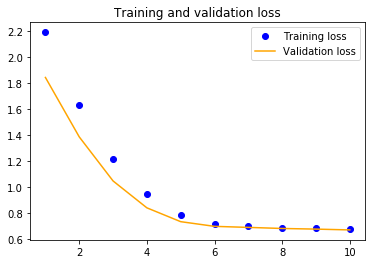

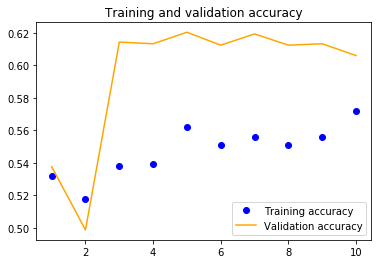

In [158]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

----------------------------------------------------------------------------  
### EVERYTHING BELOW THIS LINE IS OLD. KEEPING ONLY FOR REPURPOSING IF NEEDED.  
----------------------------------------------------------------------------

In [7]:
# Define unique set of counties
counties = county_counts['county']
counties.sort()

# Create index table of each value in the independent variable field selected
field = 'deaths'
ind = dd[field].unique()
ind.sort()
ind = pd.DataFrame({'value': ind, 'index': [i for i in range(len(ind))]})

# Create a max value for padding purposes
mm = max(dd['county'].value_counts())
feature = []
# Loop through each county
for county in counties:
    # Create a temporary list of the independent variable field for the current county in the for loop
    tmp = list(dd.loc[dd['county'] == county,field])
    # Find how many 0s to pad
    pad = mm - len(tmp)
    if pad > 0:
        # When the pad is >0 add in the 0s to the beginning of the list
        tmp.insert(0, list(np.repeat(0, mm - len(tmp))))
        # After inserting 0s, we now have a list within a list
        # Use this next loop to flatten the list so it is only a list of numbers
        new_tmp = []
        for obj in tmp:
            if type(obj) == list:
                for item in obj:
                    new_tmp.append(item)
            else:
                new_tmp.append(obj)
    # Instead of the actual values in the independent variable field, we need their respective indexes
    # This map/lambda looks up the indexes from the 'ind' table for each value in the new_tmp list
    new_tmp = [int(x) for x in map(lambda x: ind.loc[ind['value'] == x,'index'],new_tmp)]
    # Add each list after each iteration of the for loop to the feature list
    feature.append(new_tmp)
feature = np.array(feature)
# Should now have an array of A x B, where A = # of counties & B = # of values in the independent variable field

# Create a label object with 1s (for issued stay-at-home) and 0s (for did not issue stay-at-home) for each county in 'counties'
label = []
for county in counties:
    tmp = dd.loc[dd['county'] == county,'SAH']
    label.append(max(list(tmp)))
label = np.array(label)

0.4714693295292439

In [10]:
# Define unique set of counties
counties = dd['county'].unique()
counties.sort()

# Create index table of each value in the independent variable field selected
field = 'deaths'
ind = dd[field].unique()
ind.sort()
ind = pd.DataFrame({'value': ind, 'index': [i for i in range(len(ind))]})

# Create a max value for padding purposes
mm = max(dd['county'].value_counts())
feature = []
# Loop through each county
for county in counties:
    # Create a temporary list of the independent variable field for the current county in the for loop
    tmp = list(dd.loc[dd['county'] == county,field])
    # Find how many 0s to pad
    pad = mm - len(tmp)
    if pad > 0:
        # When the pad is >0 add in the 0s to the beginning of the list
        tmp.insert(0, list(np.repeat(0, mm - len(tmp))))
        # After inserting 0s, we now have a list within a list
        # Use this next loop to flatten the list so it is only a list of numbers
        new_tmp = []
        for obj in tmp:
            if type(obj) == list:
                for item in obj:
                    new_tmp.append(item)
            else:
                new_tmp.append(obj)
    # Instead of the actual values in the independent variable field, we need their respective indexes
    # This map/lambda looks up the indexes from the 'ind' table for each value in the new_tmp list
    new_tmp = [int(x) for x in map(lambda x: ind.loc[ind['value'] == x,'index'],new_tmp)]
    # Add each list after each iteration of the for loop to the feature list
    feature.append(new_tmp)
feature = np.array(feature)
# Should now have an array of A x B, where A = # of counties & B = # of values in the independent variable field

# Create a label object with 1s (for issued stay-at-home) and 0s (for did not issue stay-at-home) for each county in 'counties'
label = []
for county in counties:
    tmp = dd.loc[dd['county'] == county,'SAH']
    label.append(max(list(tmp)))
label = np.array(label)

In [11]:
# Split into training and validation @70/30
train_rows = sample(range(feature.shape[0]), math.floor(0.7*feature.shape[0]))
test_rows = [i for i in range(feature.shape[0]) if i not in train_rows]

x_train = np.array(feature[train_rows])
y_train = np.array(label[train_rows])
x_test = np.array(feature[test_rows])
y_test = np.array(label[test_rows])

x_train = tf.convert_to_tensor(x_train, tf.float32)
x_test = tf.convert_to_tensor(x_test, tf.float32)

In [12]:
# Simple RNN model
model = models.Sequential()
model.add(layers.Embedding(ind.shape[0]+3, 8))
model.add(layers.SimpleRNN(8, dropout=0.3, recurrent_dropout=0.2, kernel_regularizer=l2(0.1), return_sequences=True))
model.add(layers.SimpleRNN(8, dropout=0.3, recurrent_dropout=0.2, kernel_regularizer=l2(0.1), return_sequences=True))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=11,
                    validation_data=(x_test, y_test)
                   )

Train on 981 samples, validate on 421 samples
Epoch 1/10
981/981 [==============================] - 26s 26ms/sample - loss: 1.7636 - accuracy: 0.6360 - val_loss: 1.4614 - val_accuracy: 0.7150
Epoch 2/10
981/981 [==============================] - 22s 23ms/sample - loss: 1.3061 - accuracy: 0.6749 - val_loss: 1.0913 - val_accuracy: 0.7150
Epoch 3/10
981/981 [==============================] - 36s 37ms/sample - loss: 0.9876 - accuracy: 0.6853 - val_loss: 0.8519 - val_accuracy: 0.7150
Epoch 4/10
981/981 [==============================] - 24s 24ms/sample - loss: 0.8000 - accuracy: 0.6969 - val_loss: 0.7137 - val_accuracy: 0.7150
Epoch 5/10
981/981 [==============================] - 24s 25ms/sample - loss: 0.6956 - accuracy: 0.6990 - val_loss: 0.6436 - val_accuracy: 0.7150
Epoch 6/10
981/981 [==============================] - 32s 32ms/sample - loss: 0.6482 - accuracy: 0.6995 - val_loss: 0.6134 - val_accuracy: 0.7150
Epoch 7/10
981/981 [==============================] - 28s 29ms/sample - loss: 

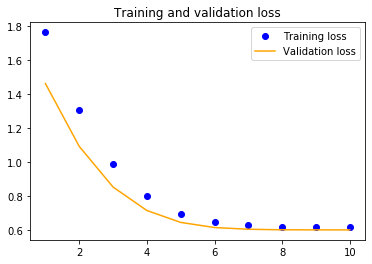

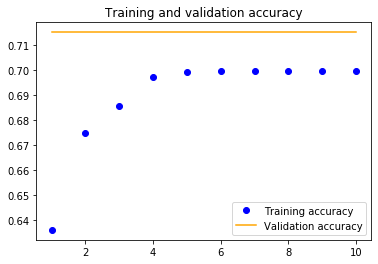

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [16]:
# LSTM model
model = models.Sequential()
model.add(layers.Embedding(ind.shape[0]+3, 8))
model.add(layers.LSTM(8, dropout=0.3, recurrent_dropout=0.2, kernel_regularizer=l2(0.1), return_sequences=True))
model.add(layers.Dense(1, activation='sigmoid'))

In [17]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=11,
                    validation_data=(x_test, y_test)
                   )

Train on 981 samples, validate on 421 samples
Epoch 1/10
981/981 [==============================] - 25s 25ms/sample - loss: 1.5737 - accuracy: 0.6993 - val_loss: 1.2232 - val_accuracy: 0.7150
Epoch 2/10
981/981 [==============================] - 35s 36ms/sample - loss: 1.0206 - accuracy: 0.6993 - val_loss: 0.8283 - val_accuracy: 0.7150
Epoch 3/10
981/981 [==============================] - 28s 29ms/sample - loss: 0.7494 - accuracy: 0.6993 - val_loss: 0.6523 - val_accuracy: 0.7150
Epoch 4/10
981/981 [==============================] - 24s 24ms/sample - loss: 0.6341 - accuracy: 0.6993 - val_loss: 0.6023 - val_accuracy: 0.7150
Epoch 5/10
981/981 [==============================] - 26s 26ms/sample - loss: 0.6168 - accuracy: 0.6993 - val_loss: 0.5993 - val_accuracy: 0.7150
Epoch 6/10
981/981 [==============================] - 29s 30ms/sample - loss: 0.6149 - accuracy: 0.6993 - val_loss: 0.5985 - val_accuracy: 0.7150
Epoch 7/10
981/981 [==============================] - 27s 27ms/sample - loss: 

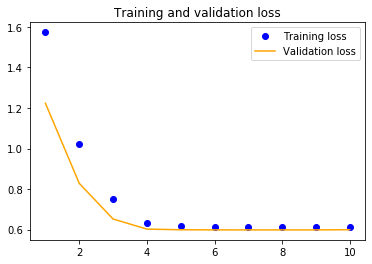

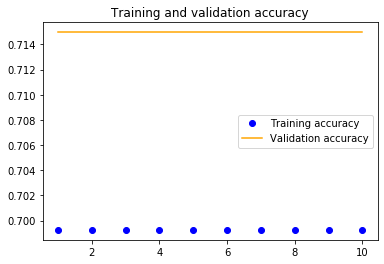

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [21]:
sum(y_test)/len(y_test)

0.7149643705463183